# <a>Classificação de Imagens - PyTorch e Transfer Learning</a>

Projeto realizado durante a Jornada Cientista de Dados da equipe <i>Let's Data</i>

# <a>Objeto de Estudo</a>

Iremos modelar um Produto Mínimo Viável que possa ser testado nas filiais de uma empresa do ramo de supermercados. O problema a ser solucionado é classificar produtos na hora de colocar no mostruário. Vamos começar com uma classificação simples de batatas, cenouras, tomates e limões.

Para isso iremos usar modelos pré-treinados para nos ajudar com a classificação de imagens através dos padrões.

<b>Criação e Separação de Bases:</b>

In [1]:
!pip install tbb

In [2]:
!pip install pillow

In [3]:
!pip install torch

In [4]:
!pip install torchvision --user

In [5]:
!pip show torchvision

Name: torchvision
Version: 0.18.1
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: c:\users\rhyan\appdata\roaming\python\python310\site-packages
Requires: numpy, pillow, torch
Required-by: 


In [6]:
# Importando as bibliotecas necessárias:
from matplotlib import pyplot as plt
import numpy as np
import os
import PIL.Image

In [7]:
import time
import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

In [8]:
# Vamos separar as imagens em bases de treino, validação e teste
# Mas antes vamos deixar salva uma pasta raw com as originais

diretorio_base_imagens = 'C:\\data_science\\projeto-classificacao-imagens\\data\\raw'
pastas_com_nome_de_vegetais = os.listdir('C:\\data_science\\projeto-classificacao-imagens\\data\\raw')
pastas_com_nome_de_vegetais

['batata', 'cenoura', 'limao', 'tomate']

In [9]:
pastas_com_nome_de_vegetais

['batata', 'cenoura', 'limao', 'tomate']

In [10]:
# Vamos criar uma separação estratificada:
# Queremos 80% das imagens na base de treino, 10% na validação e 10% no teste

quantidade_por_label = {pasta: len(os.listdir(os.path.join(diretorio_base_imagens, pasta))) for pasta in pastas_com_nome_de_vegetais}
quantidade_por_label

{'batata': 146, 'cenoura': 181, 'limao': 111, 'tomate': 107}

In [11]:
# Criando as pastas de treino, validação e testes

diretorio_imagens_processadas = 'C:\\data_science\\projeto-classificacao-imagens\\data\\processed'

dir_treino = os.path.join(diretorio_imagens_processadas, 'treino')
dir_validacao = os.path.join(diretorio_imagens_processadas, 'validacao')
dir_teste = os.path.join(diretorio_imagens_processadas, 'teste')

if not os.path.exists(dir_treino):
    os.makedirs(dir_treino)

if not os.path.exists(dir_validacao):    
    os.makedirs(dir_validacao)

if not os.path.exists(dir_teste):
    os.makedirs(dir_teste)

In [12]:
#Separando as imagens nas bases:

import shutil
from sklearn.model_selection import train_test_split

# Criando uma pasta para cada classe (batata, cenoura, limao, tomate)
# dentro de treino, validação e teste

for classe in pastas_com_nome_de_vegetais:
    # os.path.join cria paths com os separadores corretos pra cada sistema operacional
    # barra normal, barra invertida, isso muda do Windows pro Linux/Mac
    dir_classe_treino = os.path.join(dir_treino, classe)
    dir_classe_validacao = os.path.join(dir_validacao, classe)
    dir_classe_teste = os.path.join(dir_teste, classe)
    
    # Efetivamente criando as pastas de treino, validação e teste
    # Testa primeiro se as pastas já não existem
    if not os.path.exists(dir_classe_treino):
        os.makedirs(dir_classe_treino)

    if not os.path.exists(dir_classe_validacao):
        os.makedirs(dir_classe_validacao)
    
    if not os.path.exists(dir_classe_teste):
        os.makedirs(dir_classe_teste)
    
    # caminho completo para a pasta com imagens originais
    pasta_classe = os.path.join(diretorio_base_imagens, classe)
    
    # listando todos os arquivos de imagem para essa classe
    arquivos_classe = os.listdir(pasta_classe)
    
    # separando 80% para treino e 20% para validação+teste
    treino, valid_teste = train_test_split(arquivos_classe, 
                                           shuffle=True, 
                                           test_size=0.2, 
                                           random_state=42)
    
    # separando os 20% da validação+teste em 10% para validação e 10% para teste
    validacao, teste = train_test_split(valid_teste, shuffle=True, test_size=0.5, random_state=42)
    
    # Não precisamos mais dessa lista temporária
    del valid_teste
    
    print(f'{classe} - treino: {len(treino)} - valid: {len(validacao)} - teste: {len(teste)} - total: {len(arquivos_classe)}')
    
    # Copiando os arquivos efetivamente para as pastas de treino, validação e teste
    for imagem_treino in treino:
        caminho_origem = os.path.join(diretorio_base_imagens, classe, imagem_treino)
        caminho_destino = os.path.join(dir_classe_treino, imagem_treino)

        shutil.copy(caminho_origem, caminho_destino)

    for imagem_validacao in validacao:
        caminho_origem = os.path.join(diretorio_base_imagens, classe, imagem_validacao)
        caminho_destino = os.path.join(dir_classe_validacao, imagem_validacao)

        shutil.copy(caminho_origem, caminho_destino)

    for imagem_teste in teste:
        caminho_origem = os.path.join(diretorio_base_imagens, classe, imagem_teste)
        caminho_destino = os.path.join(dir_classe_teste, imagem_teste)

        shutil.copy(caminho_origem, caminho_destino)  

batata - treino: 116 - valid: 15 - teste: 15 - total: 146
cenoura - treino: 144 - valid: 18 - teste: 19 - total: 181
limao - treino: 88 - valid: 11 - teste: 12 - total: 111
tomate - treino: 85 - valid: 11 - teste: 11 - total: 107


<b>Pré Processamento:</b>

Vamos efetivamente processar as imagens para utilizar no modelo do Pytorch. Vamos criar as transformações para redimensionar as imagens e transformá-las em tensores Pytorch.

In [13]:
# Setando o tamanho da imagem
image_size = 100

# Transformando as imagens: para modelos mais robustos tem que caprichar no data augmentation!
# Nesse caso não fizemos nada além do redimensionamento da imagem, mas é sempre bom fazer rotações,
# espelhamentos, crop randomicos pra garantir 
transformacoes_de_imagens = { 
    'treino': transforms.Compose([
        transforms.Resize(size=[image_size, image_size]),
        transforms.ToTensor(),
    ]),
    'validacao': transforms.Compose([
        transforms.Resize(size=[image_size, image_size]),
        transforms.ToTensor(),
    ]),
    'teste': transforms.Compose([
        transforms.Resize(size=[image_size, image_size]),
        transforms.ToTensor(),
    ])
}

In [14]:
# Carregar as imagens
# Determinar as pastas de treino, validação e teste

pasta_treino = dir_treino
pasta_validacao = dir_validacao
pasta_teste = dir_teste

pasta_treino, pasta_validacao, pasta_teste

('C:\\data_science\\projeto-classificacao-imagens\\data\\processed\\treino',
 'C:\\data_science\\projeto-classificacao-imagens\\data\\processed\\validacao',
 'C:\\data_science\\projeto-classificacao-imagens\\data\\processed\\teste')

<b>Preparação para o treinamento:</b>

Vamos definir informações importantes para o treinamento do modelo. Tamanho do batch, número de classes, datasets, data loaders, otimizadores.

In [15]:
# Tamanho do batch de treinamento
tamanho_do_batch = 8

# Determinando o número de classes (verduras/frutas)
numero_de_classes = len(os.listdir(pasta_treino))

numero_de_classes

4

In [16]:
# Carregar as imagens usando o datasets do torchvision
data = {
    'treino': datasets.ImageFolder(root=pasta_treino, transform=transformacoes_de_imagens['treino']),
    'validacao': datasets.ImageFolder(root=pasta_validacao, transform=transformacoes_de_imagens['validacao'])
}

In [17]:
data

{'treino': Dataset ImageFolder
     Number of datapoints: 433
     Root location: C:\data_science\projeto-classificacao-imagens\data\processed\treino
     StandardTransform
 Transform: Compose(
                Resize(size=[100, 100], interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 'validacao': Dataset ImageFolder
     Number of datapoints: 55
     Root location: C:\data_science\projeto-classificacao-imagens\data\processed\validacao
     StandardTransform
 Transform: Compose(
                Resize(size=[100, 100], interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            )}

In [18]:
# Mapear os índices com os nomes das classes
indice_para_classe = {indice: classe for classe, indice in data['treino'].class_to_idx.items()}

indice_para_classe

{0: 'batata', 1: 'cenoura', 2: 'limao', 3: 'tomate'}

In [19]:
# Quantidade de imagens para serem utilizados para calcular erro médio e acurácia
num_imagens_treino = len(data['treino'])
num_imagens_validacao = len(data['validacao'])

num_imagens_treino, num_imagens_validacao

(433, 55)

In [20]:
# Cria os DataLoaders para treino e validação
# O DataLoader organiza os dados de treinamento e validação para o treinamento da rede neural
data_loader_treino = DataLoader(data['treino'], batch_size=tamanho_do_batch, shuffle=True)
data_loader_validacao = DataLoader(data['validacao'], batch_size=tamanho_do_batch, shuffle=True)

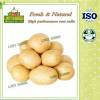

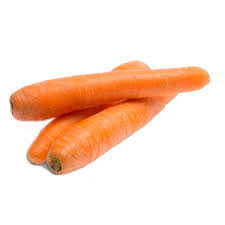

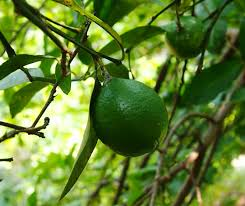

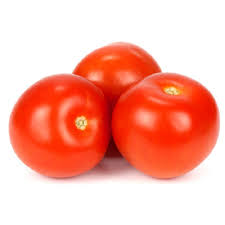

In [21]:
# Checando algumas imagens para verificar se está tudo correto até aqui:
from IPython.display import Image 

for classe in indice_para_classe.values():
    pasta_classe = os.path.join(pasta_treino, classe)
    arquivo_imagem = os.listdir(pasta_classe)[1]
    img = Image(filename=os.path.join(pasta_classe, arquivo_imagem))
    display(img)

<b>Transfer Learning:</b>

Como temos poucas imagens precisamos de uma rede pré-treinada para nos ajudar na classificação. Vamos usar a Alexnet.

In [22]:
alexnet = models.alexnet(pretrained=True)
alexnet

C:\Users\rhyan\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\rhyan\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\rhyan/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:52<00:00, 4.66MB/s] 


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [23]:
type(alexnet)

torchvision.models.alexnet.AlexNet

In [24]:
# Vamos congelar os parâmetros da rede pré-treinada, para que eles não aprendam tudo de novo:
for param in alexnet.parameters():
    param.requires_grad = False
# Isso vai desligar o treinamento e atualização dos coeficientes das camadas da rede neural

In [25]:
# Precisamos mudar a última camada para alterar o número de classes
# O restante da rede foi aproveitado, porém precisamos que ela aprenda os padrões dentro das nossas 4 classes

alexnet.classifier[6] = nn.Linear(4096, numero_de_classes)

# Incluindo o softmax, que converte efetivamente em probabilidade de ser uma das 4 classas:
alexnet.classifier.add_module("7", nn.LogSoftmax(dim = 1))

alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [26]:
parametros_ultima_camada = alexnet.classifier[6].parameters()

[parametro for parametro in parametros_ultima_camada][0].requires_grad

True

In [27]:
# Vamos utilizar a função de erro de entropia cruzada, o mais utilizado em problemas de classficiação:

funcao_erro = nn.CrossEntropyLoss()

<b>Otimizador:</b>

O otimizador é quem efetivamente altera os pesos da rede de acordo com algum algoritmo. Nesse caso, vamos utilizar o Adam Optimizer, mas o Stochastic Gradient Descent também funciona.

In [28]:
# Passando os parâmetros para o otimizador alterá-los:
otimizador = optim.Adam(alexnet.parameters())
otimizador

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

<b>Treinar e Validar:</b>

O treinamento realiza vários caminhos para frente (forward:previsão -- começa com uma previsão fraca e conforme ele anda pra frente e pra trás ele vai melhorando as previsões), cálculos de erro (distancia entre previsão e valor real) e para traz (backward: aprendizado com o erro). A cade "época" todas as imagens do treino são utilizadas para otimizar os parâmetros da rede. Dentro de cada "época", utilizamos o treinamento em batch, ao invés de imagem por imagem.

Na validação não queremos manter o cálculo de gradientes, pois não vamos fazer backpropagation.

In [29]:
def treinar_e_validar(modelo, metrica_erro, otimizador, epocas=10):
    '''
    Função para treinamento e validação
    Parâmetros
        :param modelo: modelo para treinar e validar
        :param metrica_erro: critério de erro para minização
        :param otimizador: otimizador para alterar os parâmetros da rede
        :param epocas: número de épocas (default=10)
  
    Retorna
        melhor_modelo: modelo treinado com a melhor acurácia na validação
        historico: (dicionário): histórico com erro no treinamento, erro na validação e acurácia
    '''
    
    # inicializando historico
    # a melhor acuracia de validação
    # melhor modelo de acordo com a validação
    historico = []
    melhor_acuracia = 0.0
    melhor_modelo = None
    
    # A CPU provavelmente vai dar conta do recado!
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    print(device)
    
    # Cada época perpassa todas as imagens do treino e calcula erros de treino e validação
    # para aprendizado da rede neural
    for epoca in range(epocas):
        inicio_epoca = time.time()
        print("\n\nÉpoca: {}/{}".format(epoca+1, epocas))
        
        # Erro e acurácia de treino nessa época
        erro_treino = 0.0
        acertos_treino = 0.0
        
        # Erro e acurácia de validação nessa época
        erro_validacao = 0.0
        acertos_validacao = 0.0
        
        # Itera a cada lote de imagem. As entradas são os tensores do lote (batch)
        # e o label são as classificações de cada imagem do lote: 
        # batata, cenoura, limão e tomate (0, 1, 2 e 3)
        for i, (imagens_lote, y_reais) in enumerate(data_loader_treino):
            print(f"\nLote: {i+1}\n")
            
            # joga pra GPU ou CPU, dependendo do seu hardware e pytorch instalado
            imagens_lote = imagens_lote.to(device)
            y_reais = y_reais.to(device)
            
            # Limpar os gradientes: zerar os gradientes
            otimizador.zero_grad()

            # Forward pass - calcular saídas a partir das entradas utilizando o modelo
            # Como o lote tem 8 imagens, teremos 8 previsões
            previsoes = modelo(imagens_lote)


            '''
            # Vamos entender melhor o que está se passando!
            print(imagens_lote.size()) # temos um tensor com 8 imagens
            print(previsoes) # temos tensor com 8 previsoes, cada um com 4 valores de log probabilidade
            print(torch.exp(previsoes)) # convertendo para exponencial para termos probabilidades de verdade
           
            print(torch.max(previsoes.data, 1))
           
            # Dando uma olhada nos y_reais
            print(y_reais)


            # Vamos dar uma olhadinha nas imagens do batch!
            for indice in range(tamanho_do_batch):
                tensor_para_imagem = transforms.ToPILImage()
                imagem = tensor_para_imagem(imagens_lote[indice])
                display(imagem)

            break
            '''
                
            # Calcular erro das saidas que foram preditas no forward pass
            # comparando com as classificacoes reais (predito vs real)
            # e retorna a média dos erros (são 8 erros, lembra?)
            erro = metrica_erro(previsoes, y_reais)
           
            # O backpropagation é a junção do erro.backward() + otimizador.step()
            # erro.backward() calcula os gradientes, ou seja, qual a direção 
            # dos coeficientes para reduzir o erro
            # otimizador.step() atualiza os coeficientes de acordo com os gradientes
            # calculados no passo anterior
            
            # Realizar o cálculo dos gradientes a partir do erro de predição
            # O otimizador vai utilizar esses gradientes para saber
            # qual a direção deve atualizar os coeficientes da rede
            erro.backward()
            
            # Atualizar os parâmetros da rede de acordo com os gradientes calculados no backward
            otimizador.step()
            
            # Daqui pra frente são os cálculos de acurácia
            # para avaliar a evolução do modelo durante o treinamento
            # nas épocas
            
            # Calcular o erro total para esse lote (batch) e soma o erro no treino
            # O erro calculado já é a média dos 8 erros, portanto temos que multiplicar
            # pela quantidade de imagens do lote
            erro_treino += erro.item() * imagens_lote.size(0)
            
            # Cálculo da acurácia
            # Pra calcular a acurácia temos que buscar as classes preditas para cada imagem no lote
            
            # Cada tensor é uma imagem do lote com três posições: probabilidades de cada classe
            # torch.max vai retornar o valor da maior probabilidade, 
            # bem como a posição no tensor (tupla de saída)
            # A posição, portanto, vai indicar a classe com maior probabilidade (0,1,2 e 3)
            # 1o busca o valor máximo de cada tensor de cada imagem, que vai dar 
            # a classe final predita
            _, classes_previstas = torch.max(previsoes.data, 1)
            predicoes_corretas = (classes_previstas == y_reais).type(torch.FloatTensor)
            
            # Converter os acertos para float e calcular a acurácia média
            # do lote
            acertos = torch.mean(predicoes_corretas)
            
            # Calcular a acurácia total de treino do lote todo e adicionar a em train_acc
            acertos_treino += torch.sum(predicoes_corretas)
            
            #print("Treino - Lote número {:03d}, Erro: {:.4f}, Acurácia: {:.4f}".format(i, erro.item(), acuracia.item()))

            
        # Validação - não é necessário rastrear os gradientes, pois o modelo não vai ser treinado com a validação
        # "desliga" o autograd
        with torch.no_grad():

            # Mudando de treino para validação
            modelo.eval()

            # Iteração de validação
            for j, (imagens_lote, y_reais) in enumerate(data_loader_validacao):
                imagens_lote = imagens_lote.to(device)
                y_reais = y_reais.to(device)

                # Forward pass de validação
                # Previsão do modelo treinado nessa época
                previsoes = modelo(imagens_lote)

                # Calcular erro de validação
                # Previsto versus os verdadeiros hortifruti
                erro = metrica_erro(previsoes, y_reais)

                # Calcular erro de validação e adicionar a valid_loss
                erro_validacao += erro.item() * imagens_lote.size(0)

                # Calcular a acurácia de validação
                _, classes_previstas = torch.max(previsoes.data, 1)
                predicoes_corretas = (classes_previstas == y_reais).type(torch.FloatTensor)

                # Converter os acertos para float e calcular a acurácia média
                acertos = torch.mean(predicoes_corretas)

                # Calcular a acurácia total de validação do lote todo e adicionar a em train_acc
                acertos_validacao += torch.sum(predicoes_corretas)

                #print("Validação - Lote número: {:03d}, Erro: {:.4f}, Acurácia: {:.4f}".format(j, erro.item(), acuracia.item()))
        
        #break
        
        # Calcular a média de erro e acurácia no treino
        erro_medio_treino = erro_treino/num_imagens_treino
        acuracia_media_treino = acertos_treino/num_imagens_treino

        # Calcular a média de erro e acurácia na validação
        erro_medio_validacao = erro_validacao/num_imagens_validacao
        acuracia_media_validacao = acertos_validacao/num_imagens_validacao

        # Incluir no histórico os erros e acurácias méidas
        historico.append([erro_medio_treino, erro_medio_validacao, acuracia_media_treino, acuracia_media_validacao])
                
        fim_epoca = time.time()
    
        print("Época : {:03d}, Treino: Erro: {:.4f}, Acurácia: {:.4f}%, \n\t\tValidação : Erro : {:.4f}, Acurácia: {:.4f}%, Tempo: {:.4f}s".format(epoca+1, erro_medio_treino, acuracia_media_treino*100, erro_medio_validacao, acuracia_media_validacao*100, fim_epoca-inicio_epoca))
        
        # Testa se a acurácia na validação desse modelo nessa época é a melhor
        # Se for a melhor, salva no melhor modelo e na melhor acurácia
        if acuracia_media_validacao > melhor_acuracia:
            melhor_acuracia = acuracia_media_validacao
            #torch.save(modelo, './modelos/melhor_modelo.pt')
            melhor_modelo = modelo

    return melhor_modelo, historico